# Setup

## Import libraries

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import src.bayesian_stats as bst
import os
import pandas as pd
import arviz as az
import pymc as pm
from scipy import stats
from scipy.stats import t
from scipy.stats import norm

print(f"Running on PyMC v{pm.__version__}")

# Set colors for plotting
rpe_color = '#c51b7d'
te_color = '#276419'
plt.rcParams.update({'font.size': 18})

Running on PyMC v4.3.0


In [138]:
bst.bayesian_mixed_model_anova??

Signature:
bst.bayesian_mixed_model_anova(
    between_subj_var,
    within_subj_var,
    subj_id,
    y,
    n_samples=1000,
)
Source:   
def bayesian_mixed_model_anova(between_subj_var, within_subj_var, subj_id, y, n_samples=1000):
    """Performs Bayesian analogue of mixed model (split-plot) ANOVA.
    
    Models instance of outcome resulting from both between- and within-subjects
    factors. Outcome is measured several times from each observational unit (i.e.,
    repeated measures). 
    
    Args:
        between_subj_var: The between-subjects variable.
        withing_subj_var: The within-subjects variable.
        subj_id: The subj ID variable. 
        y: The outcome variable. 
    
    Returns: 
        PyMC Model and InferenceData objects. 
    """
    # Statistical model: Split-plot design after Kruschke Ch. 20
    # Between-subjects factor (i.e., group)
    x_between, levels_x_between, num_levels_x_between = parse_categorical(between_subj_var)
  
    # Within-subjects fa

## Define Functions

In [139]:
def robust_bayesian_mixed_model_anova(between_subj_var, within_subj_var, subj_id, y, n_samples=1000):
    """Performs Bayesian analogue of mixed model (split-plot) ANOVA.
    
    Models instance of outcome resulting from both between- and within-subjects
    factors. Outcome is measured several times from each observational unit (i.e.,
    repeated measures). 
    
    Args:
        between_subj_var: The between-subjects variable.
        withing_subj_var: The within-subjects variable.
        subj_id: The subj ID variable. 
        y: The outcome variable. 
    
    Returns: 
        PyMC Model and InferenceData objects. 
    """
    # Statistical model: Split-plot design after Kruschke Ch. 20
    # Between-subjects factor (i.e., group)
    x_between, levels_x_between, num_levels_x_between = bst.parse_categorical(between_subj_var)
  
    # Within-subjects factor (i.e., target set)
    x_within, levels_x_within, num_levels_x_within = bst.parse_categorical(within_subj_var)

    # Individual subjects
    x_subj, levels_x_subj, num_levels_x_subj = bst.parse_categorical(subj_id)

    # Dependent variable 
    mu_y = y.mean()
    sigma_y = y.std()

    a_shape, a_rate = bst.gamma_shape_rate_from_mode_sd(sigma_y / 2 , 2 * sigma_y)

    with pm.Model(coords={
        "between_subj": levels_x_between, 
        "within_subj": levels_x_within,
        "subj": levels_x_subj}
        ) as model:

        # Baseline value
        a0 = pm.Normal('a0', mu=mu_y, sigma=sigma_y * 5)

        # Deflection from baseline for between subjects factor
        sigma_B = pm.Gamma('sigma_B', a_shape, a_rate)
        aB = pm.Normal('aB', mu=0.0, sigma=sigma_B, dims="between_subj")

        # Deflection from baseline for within subjects factor
        sigma_W = pm.Gamma('sigma_W', a_shape, a_rate)
        aW = pm.Normal('aW', mu=0.0, sigma=sigma_W, dims="within_subj")

        # Deflection from baseline for combination of between and within subjects factors
        sigma_BxW = pm.Gamma('sigma_BxW', a_shape, a_rate)
        aBxW = pm.Normal('aBxW', mu=0.0, sigma=sigma_BxW, dims=("between_subj", "within_subj"))

        # Deflection from baseline for individual subjects
        sigma_S = pm.Gamma('sigma_S', a_shape, a_rate)
        aS = pm.Normal('aS', mu=0.0, sigma=sigma_S, dims="subj")

        mu = a0 + aB[x_between] + aW[x_within] + aBxW[x_between, x_within] + aS[x_subj] 
        
        #Assumes same variance
        # sigma = pm.Uniform('sigma', lower=sigma_y / 100, upper=sigma_y * 10)
        #Assumes different variances 
        sigma = pm.Uniform('sigma', lower=sigma_y / 100, upper=sigma_y * 10, dims=("between_subj", "within_subj"))

        #Prior on nu parameter
        nu_minus1 = pm.Exponential('nu_minus1', 1 / 29)
        nu = pm.Deterministic('nu', nu_minus1 + 1)     
        
        # Define likelihood 
        likelihood = pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma[x_between, x_within], observed=y)
        # likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma_y, observed=y)
        
        # Sample from the posterior
        idata = pm.sample(draws=n_samples, tune=2000, target_accept=0.95)
    
    return model, idata

In [4]:
def plot_post_predictive_ttest(data, group, post, n_samps=20):
    
    grp_names = np.unique(df1.group[df1.time=="Late"])
    var_name = data.name
    # Set colors for plotting

    grp_colors = ['#c51b7d', '#276419']
    
    x = np.linspace(np.min(post.group_mean)-np.max(post.group_std),np.max(post.group_mean)+np.max(post.group_std))
    rand_idx = np.random.choice(len(post.group_mean[0,:]), n_samps)

    fig, ax = plt.subplots(1,2, figsize=(12,3))
    ax[0].hist(data[group==grp_names[0]], bins=10, density=True, alpha=0.5, color=grp_colors[0])
    for i in rand_idx:
        y = t.pdf(x, df=post.nu[i], loc=post.group_mean[0,i], scale=post.group_std[0,i])
        ax[0].plot(x, y, c=grp_colors[0], alpha=0.2)
    ax[0].set(title=grp_names[0]+' group', ylabel='probability', xlabel=var_name)

    ax[1].hist(data[group==grp_names[1]],bins=10, density=True, alpha=0.5, color=grp_colors[1])
    for i in rand_idx:
        y = t.pdf(x, df=post.nu[i], loc=post.group_mean[1,i], scale=post.group_std[1,i])
        ax[1].plot(x, y, c=grp_colors[1], alpha=0.2)
    ax[1].set(title=grp_names[1]+' group', xlabel=var_name)
    
    plt.show()

In [5]:
def plot_mustache(mu, sigma, nu, plot_pos, width, color, ax=None):
    for m, s, n in zip(mu, sigma, nu):

        rv = t(df=n, loc=m, scale=s)
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)
        xrange_scaled = xrange*(width/xrange.max())
        ax.plot(-xrange_scaled+plot_pos, yrange, color=color, alpha=.2)

In [136]:
def plot_posterior_predictive_anova(df, y_str, post, n_mustaches):
    
    #Index group names
    group_names = np.unique(df['group'])
    time_names = np.unique(df['time'])
    
    #For indexing posterior
    burn_in = post.tuning_steps
    all_post_idx = np.arange(len(post.sample))
    post_idx = np.random.randint(burn_in+1, all_post_idx[-1], n_mustaches)

    #Plot prep
    group_colors = ['#c51b7d', '#276419']
    x_offset = [-0.15, 0.15]
    
    #Initilize plot
    fig, ax = plt.subplots(figsize=(10,5),tight_layout=True)
    ax.plot(np.arange(4), np.zeros(4), 'k')
    
    for t_idx, t in enumerate(time_names):
        for g_idx, g in enumerate(group_names):
            
            #Index and plot emperical data
            y_emp = df[y_str][df.time==t][df.group==g]
            x = norm.rvs(1+t_idx+x_offset[g_idx],0.005,len(y_emp))
            ax.plot(x, y_emp, 'o', c=group_colors[g_idx], mec='w', alpha=0.5)
            
            #Index and plot posterior data
            plot_mustache(mu=post.b0.values[post_idx]+
                          post.bB.sel(group=g).values[post_idx]+
                          post.bW.sel(time=t).values[post_idx]+
                          post.bBxW.sel(group=g,time=t).values[post_idx], 
                          sigma=post.sigma.sel(group=g,time=t).values[post_idx], 
                          nu=post.nu.values[post_idx], 
                          plot_pos=0.95+t_idx+x_offset[g_idx], 
                          width=0.15, 
                          color=group_colors[g_idx], ax=ax)
            
    ax.set(xlim=(0.5,2.5), xticks=[1,2], xticklabels=['Early', 'Late'], ylabel=y_str, title='Posterior Predictive Check (' + y_str + ')')
    plt.show()

## Load the data

In [7]:
#Change the directory
os.chdir('/Users/jonathanwood/Documents/GitHub/Reinforcement-learning-in-locomotion/Data')

df1 = pd.read_csv('E1_results_anova.txt')
df1_var = pd.read_csv('E1_variability_anova.txt')
df1_reg = pd.read_csv('E1_results_regress.txt')

# End of learning differences

In [8]:
#Run the model
model_lrn_e1, idata_lrn_e1 = bst.BEST(df1.learning[df1.time=="Late"], df1.group[df1.time=="Late"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_mean, group_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


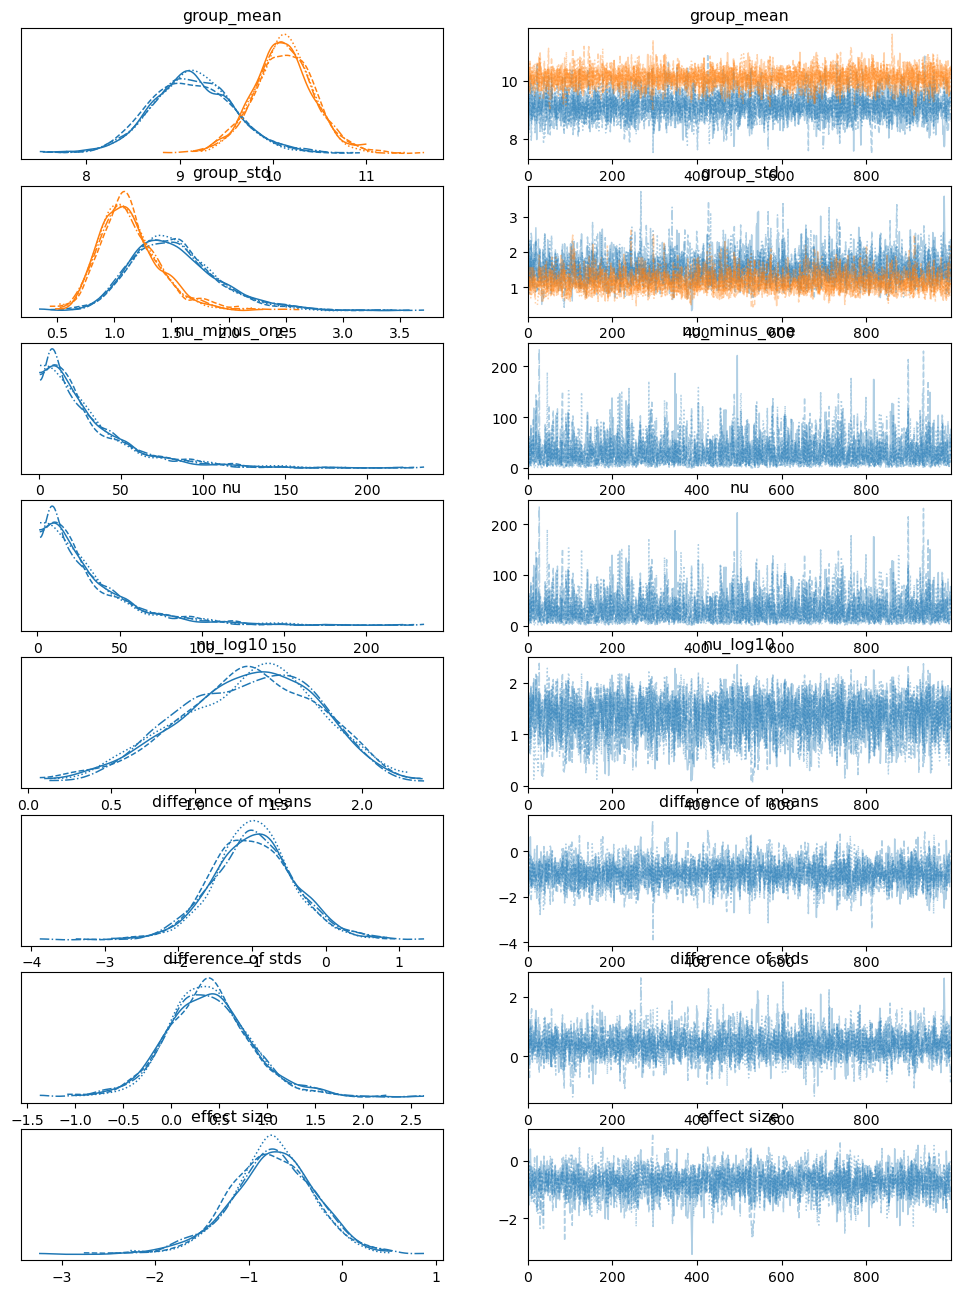

In [9]:
az.plot_trace(idata_lrn_e1);

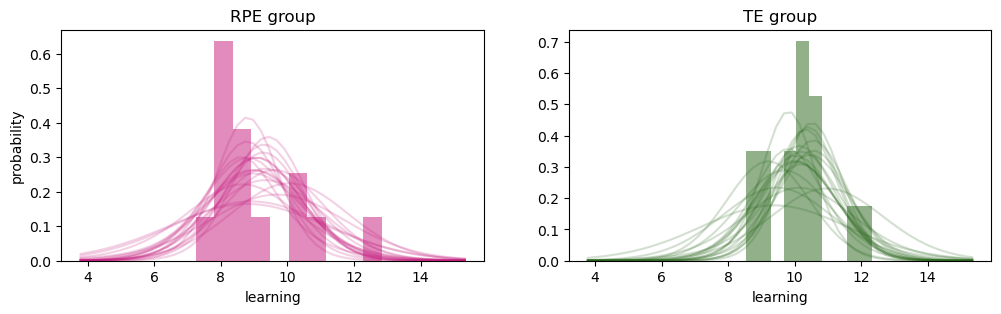

In [10]:
post = az.extract(idata_lrn_e1)
plot_post_predictive_ttest(df1.learning[df1.time=="Late"], df1.group[df1.time=="Late"], post, n_samps=20)

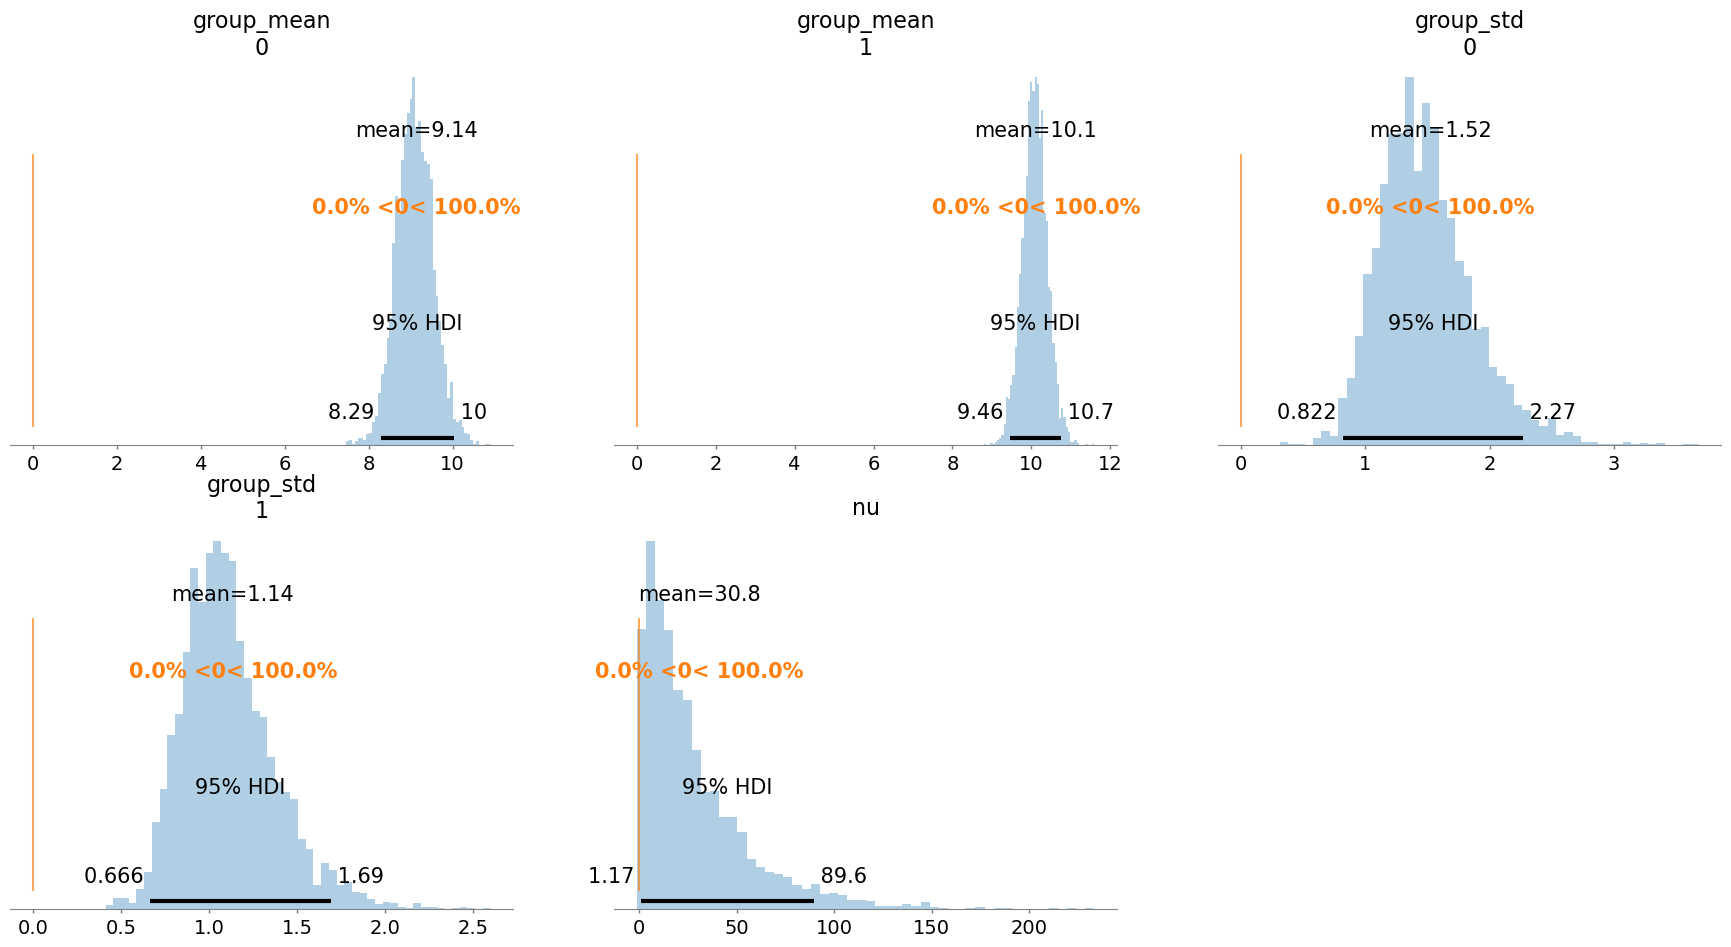

In [28]:
round_to = 3

az.plot_posterior(
    idata_lrn_e1,
    var_names=["group_mean", "group_std", "nu"],
    kind="hist",
    round_to=round_to,
    bins=50,
    hdi_prob=0.95,
    ref_val=0,
);

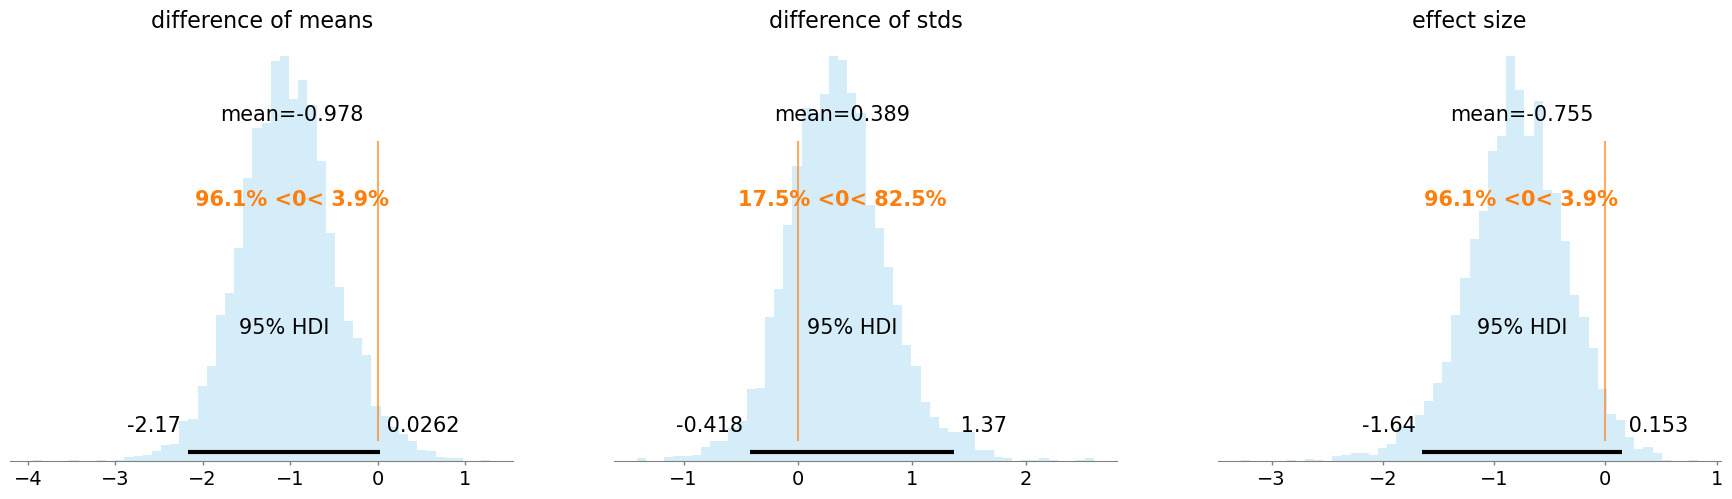

In [29]:
az.plot_posterior(
    idata_lrn_e1,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
    kind="hist",
    round_to=round_to,
    bins=50,
    hdi_prob=0.95,
);

In [32]:
e1_endlrn_summary = az.summary(idata_lrn_e1,hdi_prob=0.95)
round_to = 2

print('RPE Total Learning =', round(e1_endlrn_summary['mean'][0],round_to), '[', round(e1_endlrn_summary['hdi_2.5%'][0],round_to), round(e1_endlrn_summary['hdi_97.5%'][0],round_to), ']')
print('TE Total Learning =', round(e1_endlrn_summary['mean'][1],round_to), '[', round(e1_endlrn_summary['hdi_2.5%'][1],round_to), round(e1_endlrn_summary['hdi_97.5%'][1],round_to), ']')
print('Difference of means =', round(e1_endlrn_summary['mean'][7],round_to), '[', round(e1_endlrn_summary['hdi_2.5%'][7],round_to), round(e1_endlrn_summary['hdi_97.5%'][7],round_to), ']')

RPE Total Learning = 9.14 [ 8.3 10.03 ]
TE Total Learning = 10.12 [ 9.46 10.74 ]
Difference of means = -0.98 [ -2.17 0.03 ]


# Error Differences

In [ ]:
model_err_e1, idata_err_e1 = bayesian_two_factor_anova_robust(df1.group, df1.time, df1.error, n_draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0_tilde, sigma_a1, a1_tilde, sigma_a2, a2_tilde, sigma_a1a2, a1a2_tilde, sigma_y_sd, sigma_y_mode, sigma_y, nu_minus1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 181 seconds.


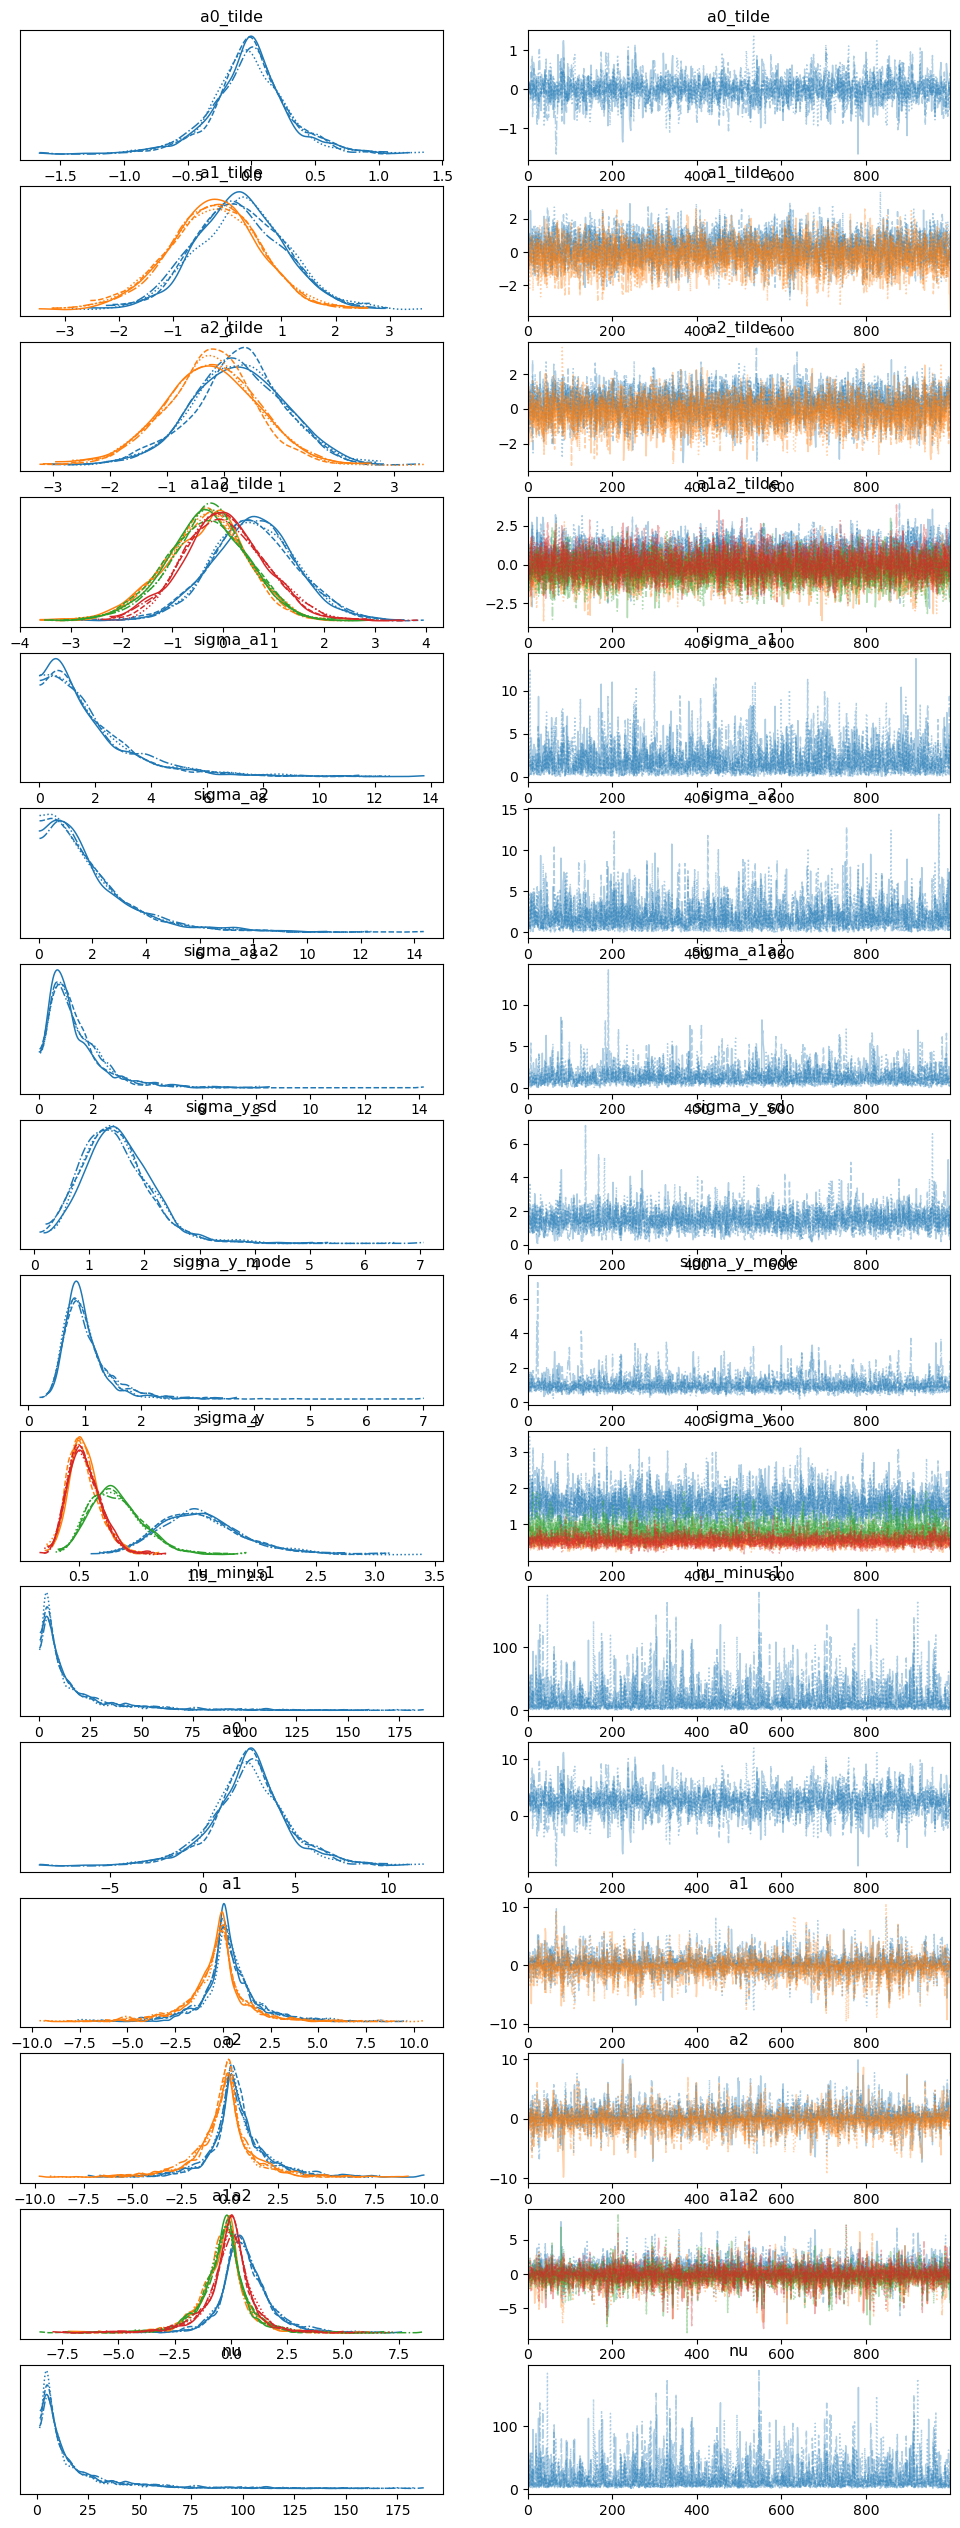

In [ ]:
az.plot_trace(idata_err_e1);

In [22]:
# Convert coefficients to sum-to-zero deflections
post_err_e1 = bst.two_factor_anova_convert_to_sum_to_zero(idata_err_e1, df1.group, df1.time)
# Rename the dimensions for easier label-based indexing
post_err_e1 = post_err_e1.rename({"factor1": "group", "factor2": "time"})

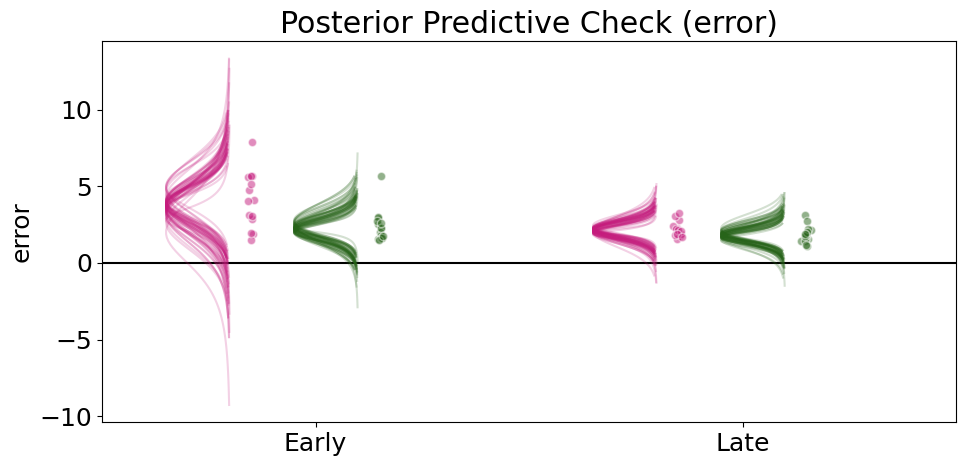

In [40]:
# Plot posterior predictive
plot_posterior_predictive_anova(df1, 'error', post_err_e1, 50)

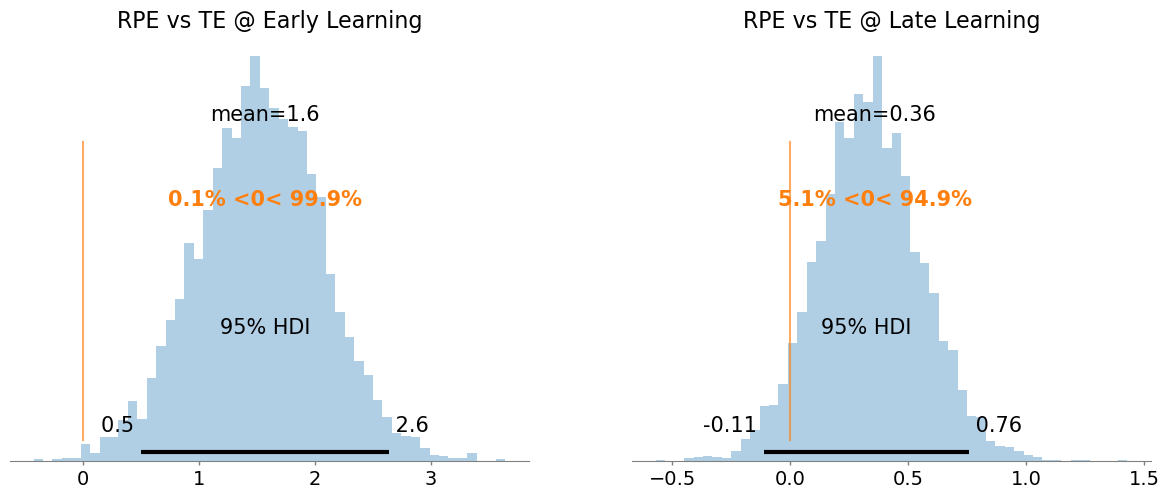

In [46]:
interaction_contrasts = {"RPE vs TE @ Early Learning": (post_err_e1.b0 + post_err_e1.b1.sel(group='RPE') + post_err_e1.b2.sel(time='Early') + post_err_e1.b1b2.sel(group='RPE',time='Early')) - 
                         (post_err_e1.b0 + post_err_e1.b1.sel(group='TE') + post_err_e1.b2.sel(time='Early') + post_err_e1.b1b2.sel(group='TE',time='Early')),
                         "RPE vs TE @ Late Learning": (post_err_e1.b0 + post_err_e1.b1.sel(group='RPE') + post_err_e1.b2.sel(time='Late') + post_err_e1.b1b2.sel(group='RPE',time='Late')) - 
                         (post_err_e1.b0 + post_err_e1.b1.sel(group='TE') + post_err_e1.b2.sel(time='Late') + post_err_e1.b1b2.sel(group='TE',time='Late'))}

round_to = 2

az.plot_posterior(interaction_contrasts, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  round_to=round_to,
                  hdi_prob=0.95);

In [45]:
rpe_early_hdi = az.hdi(post_err_e1.m.sel(group="RPE", time="Early").values, hdi_prob=0.95)
rpe_late_hdi = az.hdi(post_err_e1.m.sel(group="RPE", time="Late").values, hdi_prob=0.95)

te_early_hdi = az.hdi(post_err_e1.m.sel(group="TE", time="Early").values, hdi_prob=0.95)
te_late_hdi = az.hdi(post_err_e1.m.sel(group="TE", time="Late").values, hdi_prob=0.95)

round_to = 2

print('RPE Error during Early learning =', np.round(np.mean(post_err_e1.m.sel(group="RPE", time="Early").values),round_to), np.round(rpe_early_hdi,round_to))
print('RPE Error during Late learning =', np.round(np.mean(post_err_e1.m.sel(group="RPE", time="Late").values),round_to), np.round(rpe_late_hdi,round_to))

print('TE Error during Early learning =', np.round(np.mean(post_err_e1.m.sel(group="TE", time="Early").values),round_to), np.round(te_early_hdi,round_to))
print('TE Error during Late learning =', np.round(np.mean(post_err_e1.m.sel(group="TE", time="Late").values),round_to), np.round(te_late_hdi,round_to))

RPE Error during Early learning = 3.84 [2.9  4.82]
RPE Error during Late learning = 2.18 [1.86 2.5 ]
TE Error during Early learning = 2.28 [1.8  2.76]
TE Error during Late learning = 1.82 [1.52 2.14]


## Single subj model

In [129]:
model2_err_e1, idata2_err_e1 = robust_bayesian_mixed_model_anova(df1.group, df1.time, df1.subj_id, df1.error, n_samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, sigma_B, aB, sigma_W, aW, sigma_BxW, aBxW, sigma_S, aS, sigma, nu_minus1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 853 seconds.


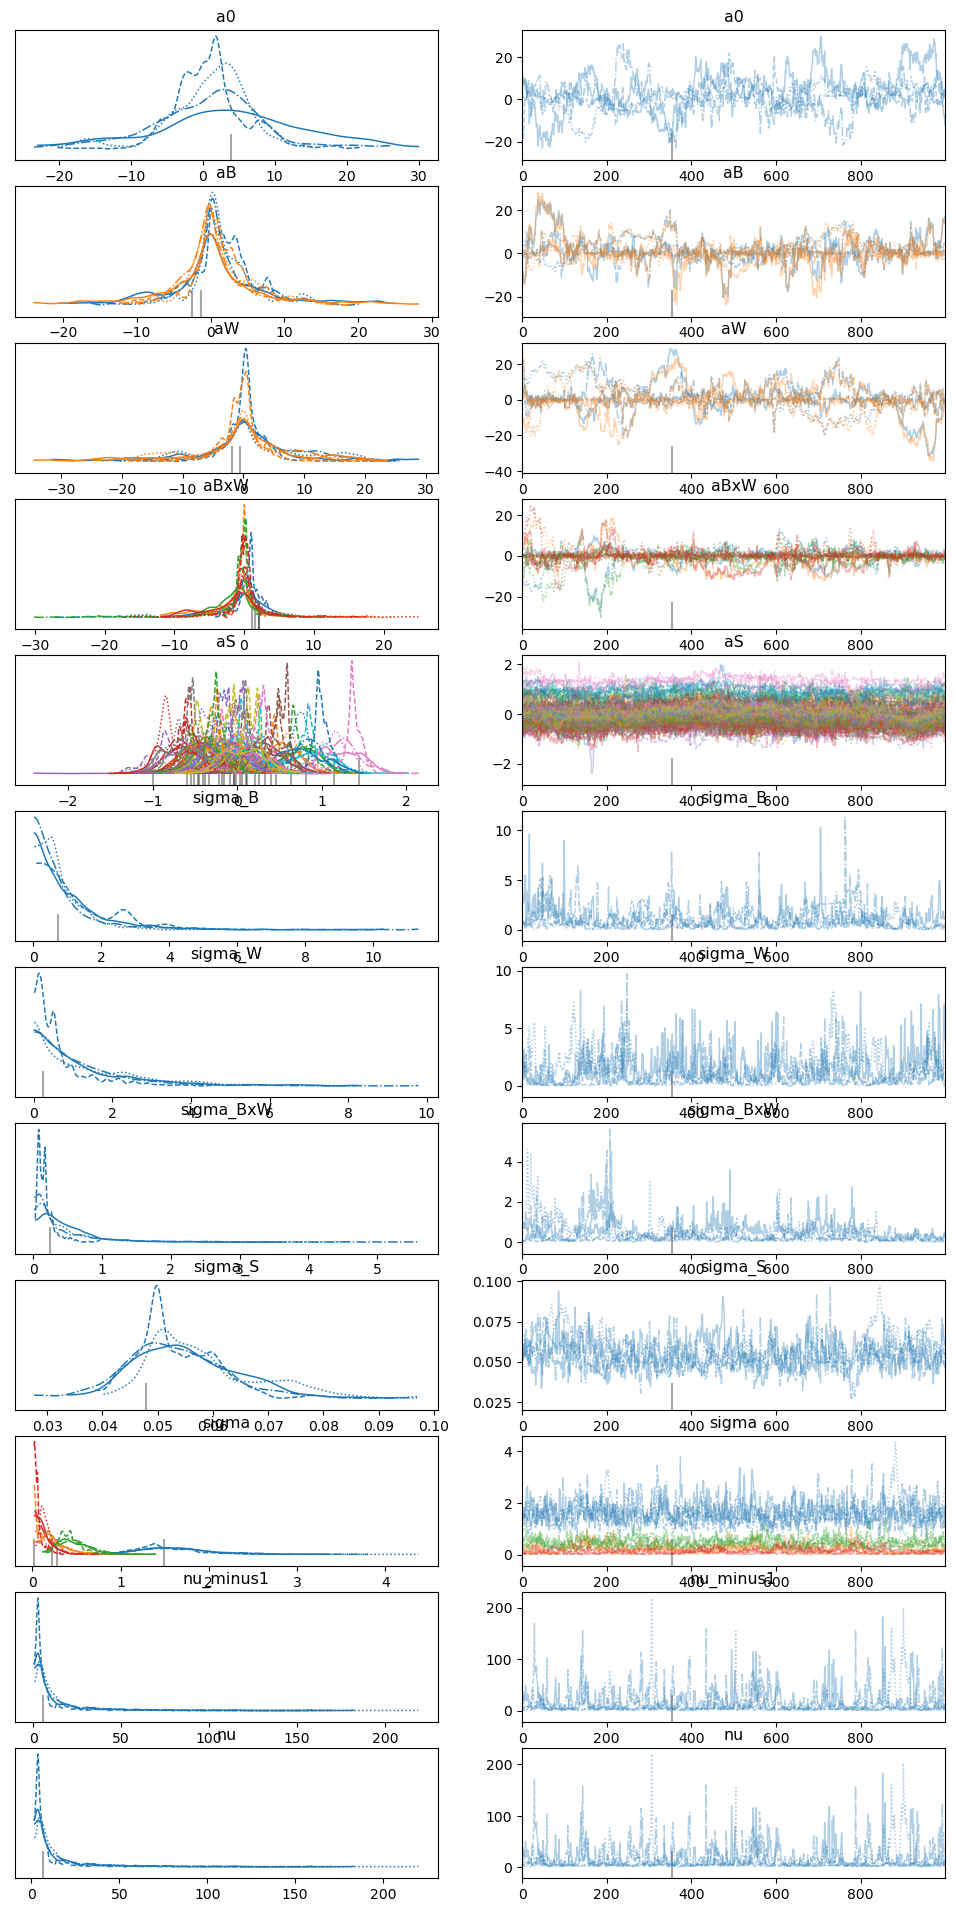

In [131]:
az.plot_trace(idata2_err_e1);

In [132]:
# Convert coefficients to sum-to-zero deflections
post2_err_e1 = bst.convert_to_sum_to_zero(idata2_err_e1, df1.group, df1.time, df1.subj_id)
# Rename the dimensions for easier label-based indexing
post2_err_e1 = post2_err_e1.rename({"between_subj": "group", "within_subj": "time"})

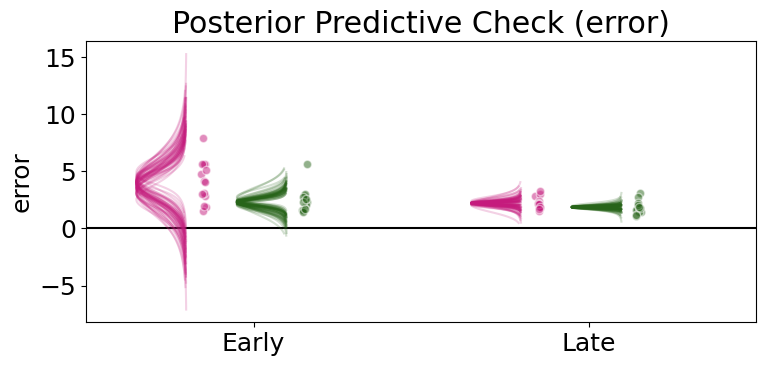

In [133]:
plot_posterior_predictive_anova(df1, 'error', post2_err_e1, 50)

RPE Error during Early learning = 3.9 [2.89 4.91]
TE Error during Early learning = 2.32 [2.05 2.62]
RPE Error during Late learning = 2.2 [2.03 2.36]
TE Error during Late learning = 1.86 [1.78 1.95]


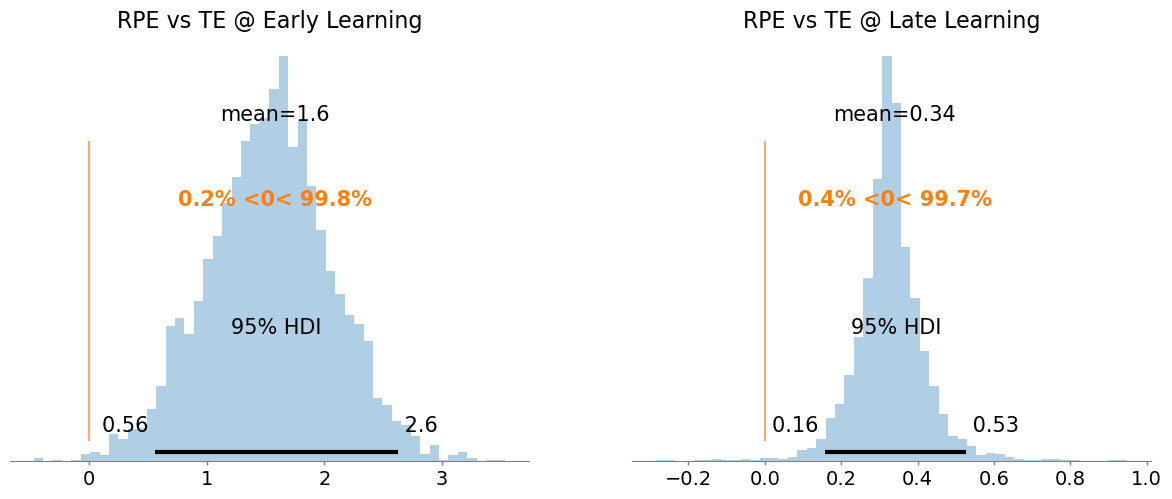

In [134]:
round_to = 2

#Index contrasts
rpe_early = post2_err_e1.b0 + post2_err_e1.bB.sel(group='RPE') + post2_err_e1.bW.sel(time='Early') + post2_err_e1.bBxW.sel(group='RPE',time='Early')
te_early = post2_err_e1.b0 + post2_err_e1.bB.sel(group='TE') + post2_err_e1.bW.sel(time='Early') + post2_err_e1.bBxW.sel(group='TE',time='Early')
rpe_late = post2_err_e1.b0 + post2_err_e1.bB.sel(group='RPE') + post2_err_e1.bW.sel(time='Late') + post2_err_e1.bBxW.sel(group='RPE',time='Late')
te_late = post2_err_e1.b0 + post2_err_e1.bB.sel(group='TE') + post2_err_e1.bW.sel(time='Late') + post2_err_e1.bBxW.sel(group='TE',time='Late')


interaction_contrasts = {"RPE vs TE @ Early Learning": rpe_early - te_early, 
                         "RPE vs TE @ Late Learning": rpe_late - te_late}
az.plot_posterior(interaction_contrasts, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  round_to=round_to,
                  hdi_prob=0.95);

#Caluclate HDIs
rpe_early_hdi = az.hdi(rpe_early.values, hdi_prob=0.95)
te_early_hdi = az.hdi(te_early.values, hdi_prob=0.95)
rpe_late_hdi = az.hdi(rpe_late.values, hdi_prob=0.95)
te_late_hdi = az.hdi(te_late.values, hdi_prob=0.95)

#Print values
print('RPE Error during Early learning =', np.round(np.mean(rpe_early.values),round_to), np.round(rpe_early_hdi,round_to))
print('TE Error during Early learning =', np.round(np.mean(te_early.values),round_to), np.round(te_early_hdi,round_to))
print('RPE Error during Late learning =', np.round(np.mean(rpe_late.values),round_to), np.round(rpe_late_hdi,round_to))
print('TE Error during Late learning =', np.round(np.mean(te_late.values),round_to), np.round(te_late_hdi,round_to))

## SS model 2

In [140]:
model3_err_e1, idata3_err_e1 = robust_bayesian_mixed_model_anova(df1.group, df1.time, df1.subj_id, df1.error, n_samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, sigma_B, aB, sigma_W, aW, sigma_BxW, aBxW, sigma_S, aS, sigma, nu_minus1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 765 seconds.


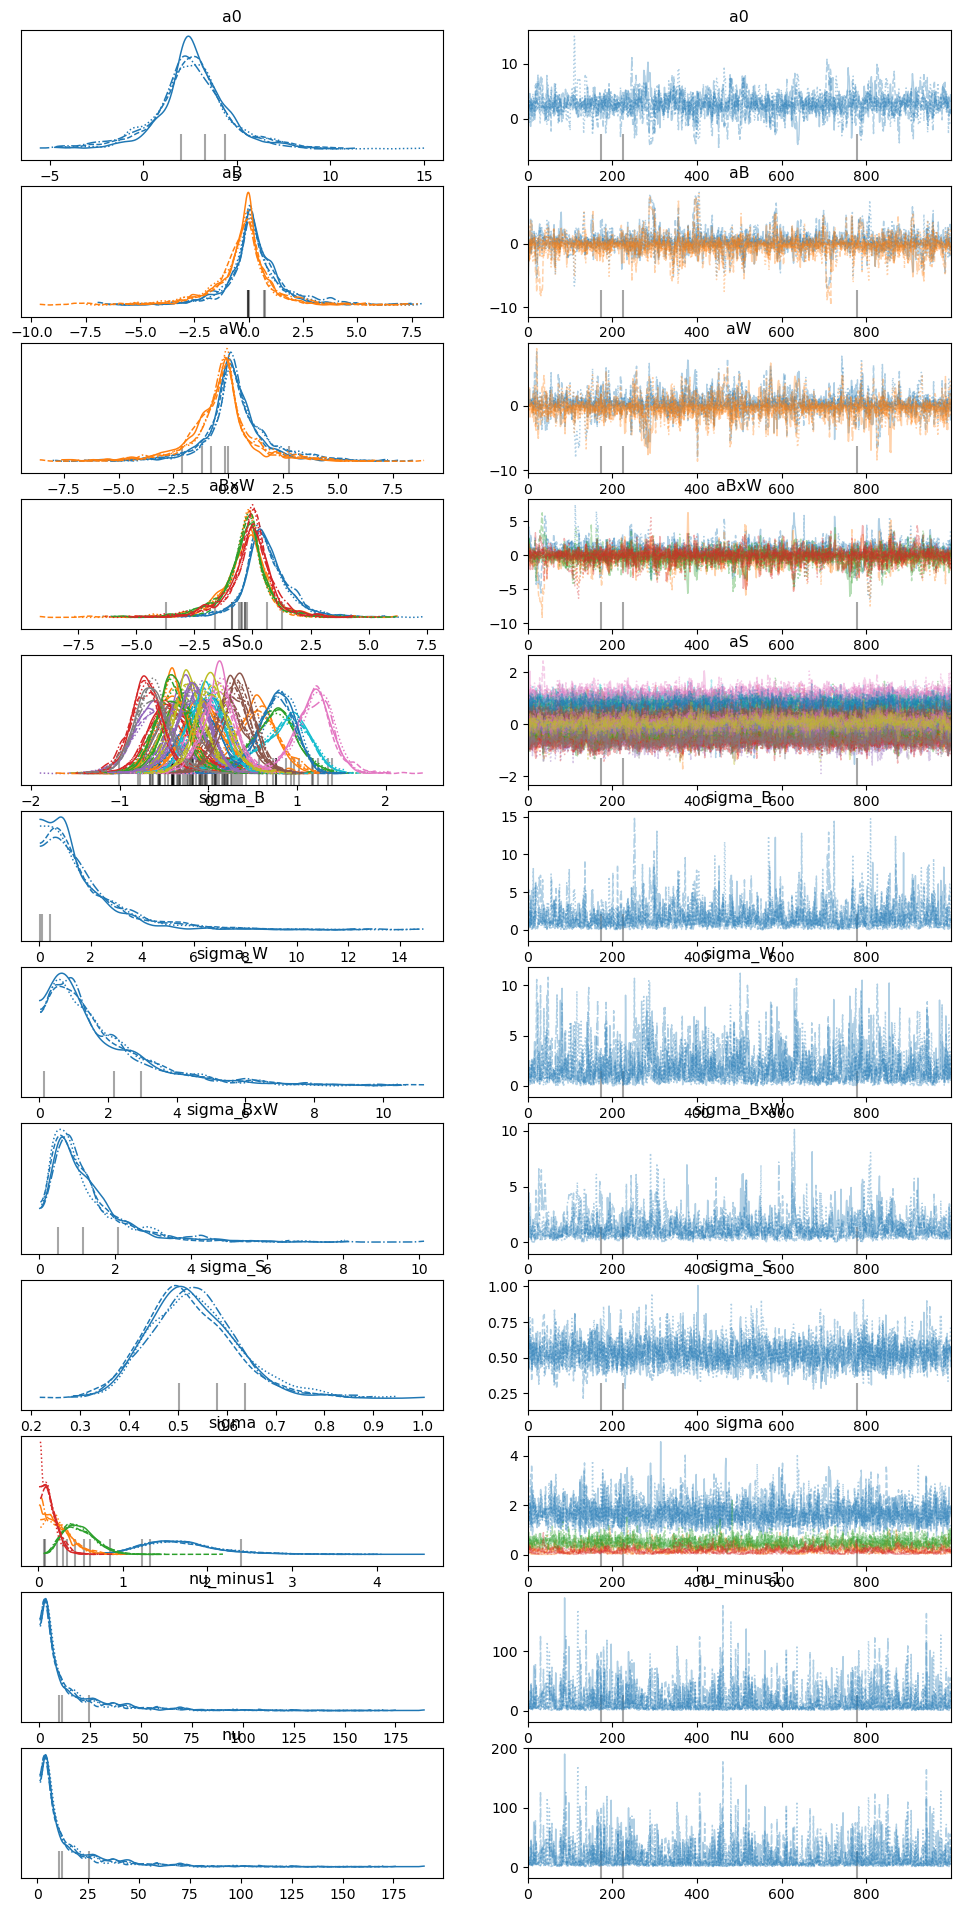

In [141]:
az.plot_trace(idata3_err_e1);

In [142]:
# Convert coefficients to sum-to-zero deflections
post3_err_e1 = bst.convert_to_sum_to_zero(idata3_err_e1, df1.group, df1.time, df1.subj_id)
# Rename the dimensions for easier label-based indexing
post3_err_e1 = post3_err_e1.rename({"between_subj": "group", "within_subj": "time"})

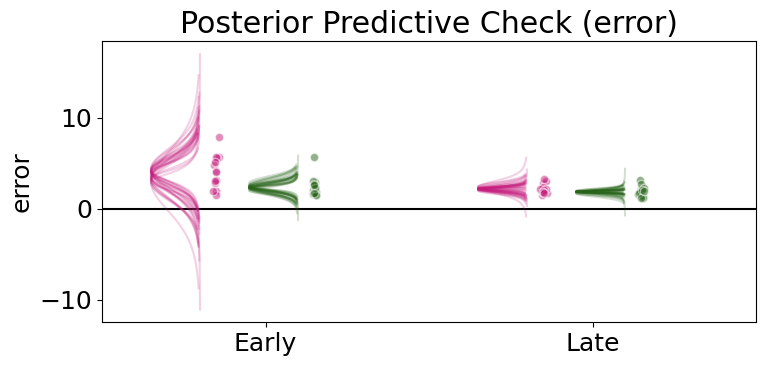

In [146]:
plot_posterior_predictive_anova(df1, 'error', post3_err_e1, 25)

In [149]:
np.mean(df1.error[df1.group=='RPE'][df1.time=='Late'])
np.mean(df1.error[df1.group=='TE'][df1.time=='Late'])

1.8625025273521394

RPE Error during Early learning = 3.75 [2.75 4.76]
TE Error during Early learning = 2.33 [2.03 2.62]
RPE Error during Late learning = 2.2 [2.02 2.39]
TE Error during Late learning = 1.86 [1.75 1.96]


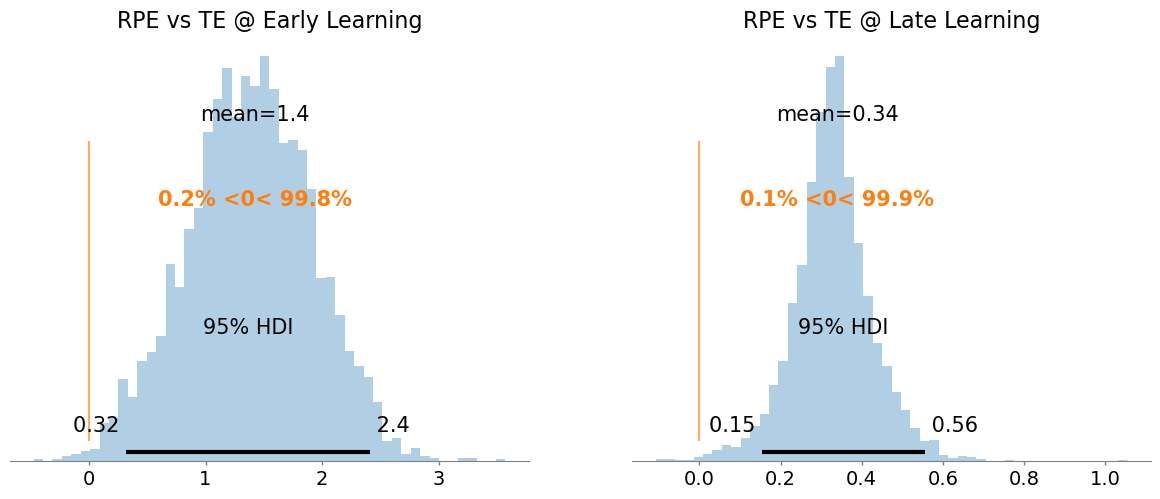

In [144]:
round_to = 2

#Index contrasts
rpe_early = post3_err_e1.b0 + post3_err_e1.bB.sel(group='RPE') + post3_err_e1.bW.sel(time='Early') + post3_err_e1.bBxW.sel(group='RPE',time='Early')
te_early = post3_err_e1.b0 + post3_err_e1.bB.sel(group='TE') + post3_err_e1.bW.sel(time='Early') + post3_err_e1.bBxW.sel(group='TE',time='Early')
rpe_late = post3_err_e1.b0 + post3_err_e1.bB.sel(group='RPE') + post3_err_e1.bW.sel(time='Late') + post3_err_e1.bBxW.sel(group='RPE',time='Late')
te_late = post3_err_e1.b0 + post3_err_e1.bB.sel(group='TE') + post3_err_e1.bW.sel(time='Late') + post3_err_e1.bBxW.sel(group='TE',time='Late')


interaction_contrasts = {"RPE vs TE @ Early Learning": rpe_early - te_early, 
                         "RPE vs TE @ Late Learning": rpe_late - te_late}
az.plot_posterior(interaction_contrasts, 
                  kind="hist",
                  combine_dims={"sample"},
                  bins=50,
                  point_estimate="mean", 
                  ref_val=0,
                  round_to=round_to,
                  hdi_prob=0.95);

#Caluclate HDIs
rpe_early_hdi = az.hdi(rpe_early.values, hdi_prob=0.95)
te_early_hdi = az.hdi(te_early.values, hdi_prob=0.95)
rpe_late_hdi = az.hdi(rpe_late.values, hdi_prob=0.95)
te_late_hdi = az.hdi(te_late.values, hdi_prob=0.95)

#Print values
print('RPE Error during Early learning =', np.round(np.mean(rpe_early.values),round_to), np.round(rpe_early_hdi,round_to))
print('TE Error during Early learning =', np.round(np.mean(te_early.values),round_to), np.round(te_early_hdi,round_to))
print('RPE Error during Late learning =', np.round(np.mean(rpe_late.values),round_to), np.round(rpe_late_hdi,round_to))
print('TE Error during Late learning =', np.round(np.mean(te_late.values),round_to), np.round(te_late_hdi,round_to))

In [150]:
az.compare({'Two Factor': idata_err_e1,
           'Subj included - narrow priors': idata3_err_e1},ic='waic')

/Users/jonathanwood/opt/anaconda3/envs/bayes_toolbox/lib/python3.11/site-packages/arviz/stats/stats.py:1644: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/jonathanwood/opt/anaconda3/envs/bayes_toolbox/lib/python3.11/site-packages/arviz/stats/stats.py:1644: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


rank  elpd_waic     p_waic  elpd_diff  \
Subj included - narrow priors     0 -50.578337  39.342093     0.0000   
Two Factor                        1 -79.162636   9.116110    28.5843   

                                     weight        se       dse  warning scale  
Subj included - narrow priors  1.000000e+00  9.612971  0.000000     True   log  
Two Factor                     7.588596e-12  8.899811  3.937196     True   log